## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [2]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [9]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
from keras.callbacks import EarlyStopping

earlystop = {'val_loss_5': EarlyStopping(monitor="val_loss", patience=5, verbose=1),
             'val_acc_5': EarlyStopping(monitor="val_acc", patience=5, verbose=1),
             'val_acc_10': EarlyStopping(monitor="val_acc", patience=10, verbose=1),
             'val_acc_25': EarlyStopping(monitor="val_acc", patience=25, verbose=1)
}

In [13]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for es in earlystop:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print(es)
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop[es]]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = es
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0805 00:04:23.118000  7708 deprecation_wrapper.py:119] From C:\Users\Hui\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0805 00:04:23.121000  7708 deprecation_wrapper.py:119] From C:\Users\Hui\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0805 00:04:23.148000  7708 deprecation_wrapper.py:119] From C:\Users\Hui\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 00:04:23.148999  7708 deprecation_wrapper.py:119] From C:\Users\Hui\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 00:04:23.152999  7708 deprecat

val_loss_5


W0805 00:04:23.399000  7708 deprecation_wrapper.py:119] From C:\Users\Hui\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0805 00:04:23.480999  7708 deprecation.py:323] From C:\Users\Hui\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 4s 85us/step - loss: 1.2207 - acc: 0.5783 - val_loss: 1.4859 - val_acc: 0.4795
Epoch 14/50
50000/50000 [==============================] - 4s 82us/step - loss: 1.1975 - acc: 0.5886 - val_loss: 1.4799 - val_acc: 0.4794
Epoch 15/50
50000/50000 [==============================] - 4s 82us/step - loss: 1.1736 - acc: 0.5959 - val_loss: 1.4802 - val_acc: 0.4784
Epoch 16/50
50000/50000 [==============================] - 4s 82us/step - loss: 1.1504 - acc: 0.6041 - val_loss: 1.4759 - val_acc: 0.4850
Epoch 17/50
50000/50000 [==============================] - 4s 82us/step - loss: 1.1257 - acc: 0.6134 - val_loss: 1.4652 - val_acc: 0.4924
Epoch 18/50
50000/50000 [==============================] - 4s 82us/step - loss: 1.1046 - acc: 0.6233 - val_loss: 1.4588 - val_acc: 0.4888
Epoch 19/50
50000/50000 [==============================] - 4s 82us/step - loss: 1.0815 - acc: 0.6302 - val_loss: 1.4670 - val_acc: 0.4875
Epoch 20/50
50000/50000 [=====================

Epoch 40/50
50000/50000 [==============================] - 4s 82us/step - loss: 0.6763 - acc: 0.7891 - val_loss: 1.5556 - val_acc: 0.5007
Epoch 41/50
50000/50000 [==============================] - 4s 82us/step - loss: 0.6578 - acc: 0.7951 - val_loss: 1.5775 - val_acc: 0.4938
Epoch 42/50
50000/50000 [==============================] - 4s 82us/step - loss: 0.6386 - acc: 0.8054 - val_loss: 1.5801 - val_acc: 0.4946
Epoch 43/50
50000/50000 [==============================] - 4s 83us/step - loss: 0.6210 - acc: 0.8123 - val_loss: 1.5973 - val_acc: 0.4878
Epoch 44/50
50000/50000 [==============================] - 4s 82us/step - loss: 0.6026 - acc: 0.8189 - val_loss: 1.5987 - val_acc: 0.4870
Epoch 45/50
50000/50000 [==============================] - 4s 83us/step - loss: 0.5875 - acc: 0.8242 - val_loss: 1.6092 - val_acc: 0.4931
Epoch 46/50
50000/50000 [==============================] - 4s 82us/step - loss: 0.5686 - acc: 0.8314 - val_loss: 1.6330 - val_acc: 0.4825
Epoch 47/50
50000/50000 [=========

50000/50000 [==============================] - 5s 93us/step - loss: 0.7102 - acc: 0.7772 - val_loss: 1.5578 - val_acc: 0.4877
Epoch 39/50
50000/50000 [==============================] - 5s 94us/step - loss: 0.6913 - acc: 0.7839 - val_loss: 1.5423 - val_acc: 0.4921
Epoch 40/50
50000/50000 [==============================] - 5s 94us/step - loss: 0.6718 - acc: 0.7935 - val_loss: 1.5725 - val_acc: 0.4894
Epoch 41/50
50000/50000 [==============================] - 4s 89us/step - loss: 0.6539 - acc: 0.7990 - val_loss: 1.5736 - val_acc: 0.4866
Epoch 42/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.6357 - acc: 0.8054 - val_loss: 1.5836 - val_acc: 0.4858
Epoch 43/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.6176 - acc: 0.8130 - val_loss: 1.5954 - val_acc: 0.4883
Epoch 44/50
50000/50000 [==============================] - 5s 94us/step - loss: 0.6006 - acc: 0.8196 - val_loss: 1.6204 - val_acc: 0.4853
Epoch 45/50
50000/50000 [=====================

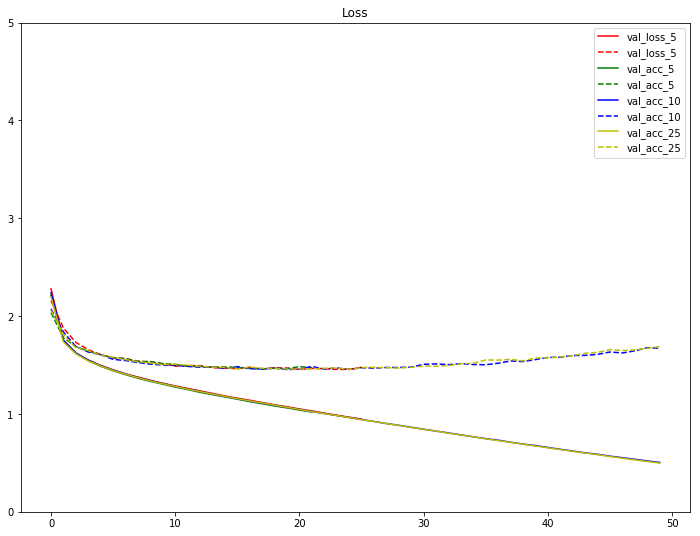

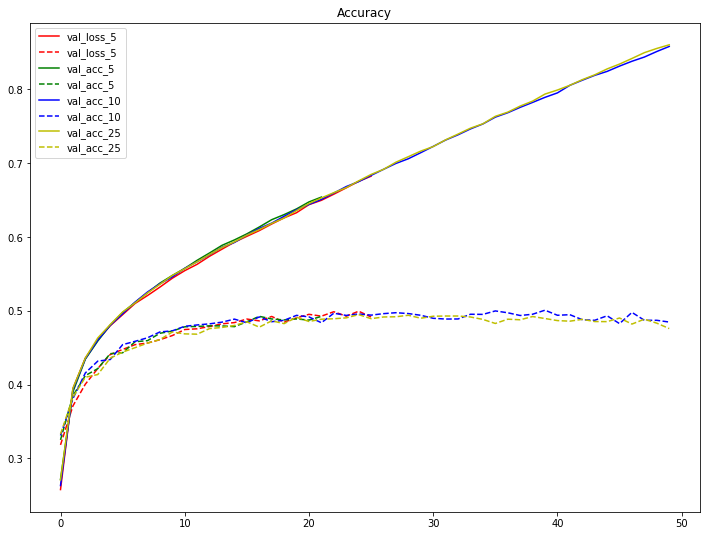

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k", "c"]

plt.figure(figsize=(12,9))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()